# Performance Evaluation, Interpretation & Insights




## Introduction






 **Goal:** Visualize model performance, compare classifiers, and prepare results for sharing or documentation.

## Setup & Imports

In [52]:
import joblib
import os
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import (
    classification_report,
    ConfusionMatrixDisplay,
    roc_curve,
    roc_auc_score,
    confusion_matrix # Added confusion_matrix import
)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


## Re-load all Models and Thresholds



In [60]:
# File path 
file_path = r"C:\Users\yasmine\Documents\Portfolio\DataSciencePortfolio\Projects\Breast-Cancer\models"

# Load models from Step 04
lr_model = joblib.load(f"{file_path}/model_lr.pkl")
gb_model = joblib.load(f"{file_path}/model_gb.pkl")

# Load thresholds
lr_threshold = joblib.load(f"{file_path}/threshold_lr.pkl")
gb_threshold = joblib.load(f"{file_path}/threshold_gb.pkl")



print("Models and thresholds loaded successfully.")


# load test set 
X_test = joblib.load(f"{file_path}/X_test.pkl")
y_test = joblib.load(f"{file_path}/y_test.pkl")

print("Reloaded test set:", X_test.shape, len(y_test))
print("Distribution:\n", y_test.value_counts())

Models and thresholds loaded successfully.
Reloaded test set: (114, 21) 114
Distribution:
 diagnosis
0    72
1    42
Name: count, dtype: int64


In [61]:
# Verify thresholds
print("Thresholds loaded:")
print("LR:", lr_threshold)
print("GB:", gb_threshold)

Thresholds loaded:
LR: 0.45
GB: 0.39


## Evaluate All Models On Test Set

In [62]:
def evaluate_models(models, thresholds, X_test, y_test):
    plt.figure(figsize=(7, 6))
    all_fpr = []
    all_tpr = []
    all_auc = []
    all_names = []

    for name, model in models.items():
        # Predict probabilities
        y_prob = model.predict_proba(X_test)[:, 1]
        # Apply tuned threshold
        y_pred = (y_prob >= thresholds[name]).astype(int)

        # Classification report
        print(f"\n=== {name.upper()} ===")
        print(classification_report(y_test, y_pred, target_names=["Benign","Malignant"]))
        print("Confusion Matrix:")
        print(confusion_matrix(y_test, y_pred))


# Example usage (assuming you reloaded models + thresholds as dicts):
models = {"lr": lr_model, "gb": gb_model}
thresholds = {"lr": lr_threshold, "gb": gb_threshold}
evaluate_models(models, thresholds, X_test, y_test)


=== LR ===
              precision    recall  f1-score   support

      Benign       0.99      1.00      0.99        72
   Malignant       1.00      0.98      0.99        42

    accuracy                           0.99       114
   macro avg       0.99      0.99      0.99       114
weighted avg       0.99      0.99      0.99       114

Confusion Matrix:
[[72  0]
 [ 1 41]]

=== GB ===
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00        72
   Malignant       1.00      1.00      1.00        42

    accuracy                           1.00       114
   macro avg       1.00      1.00      1.00       114
weighted avg       1.00      1.00      1.00       114

Confusion Matrix:
[[72  0]
 [ 0 42]]


<Figure size 700x600 with 0 Axes>

## Confusion Matrices


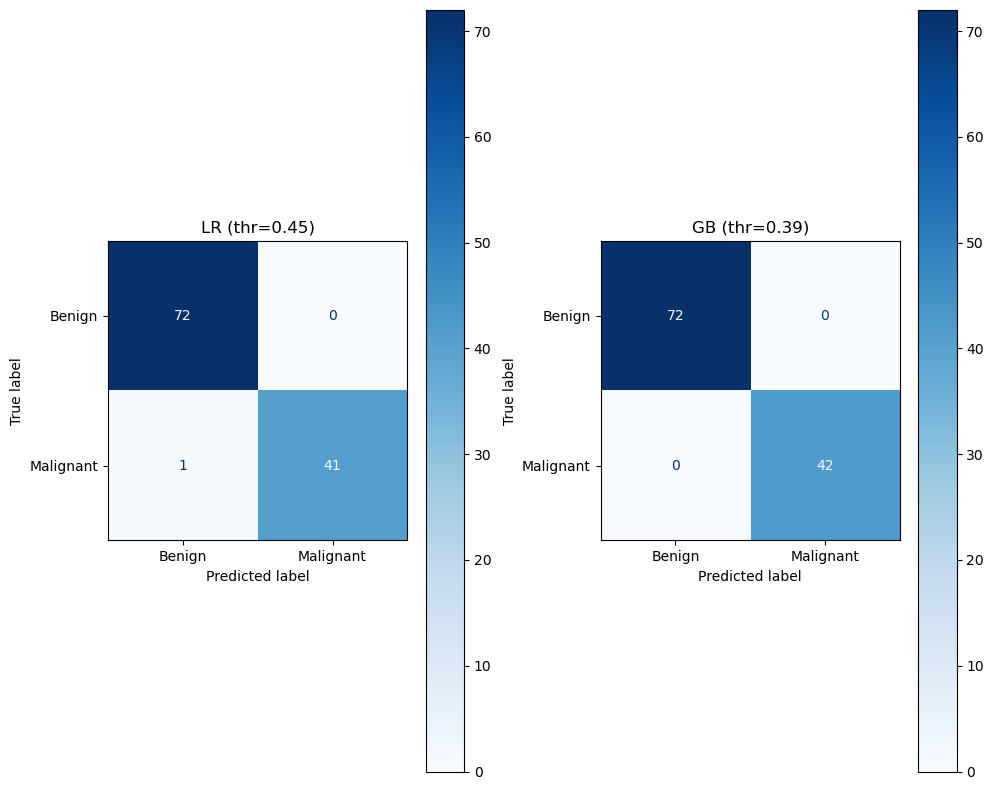

In [63]:
fig, axes = plt.subplots(1, 2, figsize=(10, 8))
axes = axes.ravel()

for i, name in enumerate(models):
    model = models[name]
    threshold = thresholds[name]

    y_prob = model.predict_proba(X_test)[:,1]
    y_pred = (y_prob >= threshold).astype(int)

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign","Malignant"])
    disp.plot(cmap="Blues", ax=axes[i], values_format="d")
    axes[i].set_title(f"{name.upper()} (thr={threshold:.2f})")

plt.tight_layout()
plt.show()

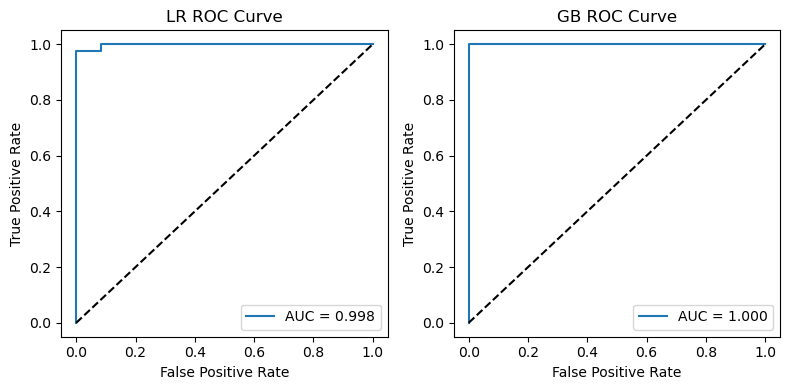

In [64]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, roc_curve, roc_auc_score # Added roc_curve, roc_auc_score

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes = axes.ravel()

for i, name in enumerate(models):
    model = models[name]
    # threshold = thresholds[name] # Threshold not directly used for ROC curve plotting itself, only for binary prediction

    y_prob = model.predict_proba(X_test)[:,1]
    # y_pred = (y_prob >= threshold).astype(int) # y_pred is not needed for ROC curve plotting

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)

    # Plot ROC curve on the current subplot
    axes[i].plot(fpr, tpr, label=f'AUC = {auc:.3f}')
    axes[i].plot([0,1],[0,1],'k--') # Diagonal line
    axes[i].set_xlabel('False Positive Rate')
    axes[i].set_ylabel('True Positive Rate')
    axes[i].set_title(f'{name.upper()} ROC Curve')
    axes[i].legend(loc='lower right')

plt.tight_layout()
plt.show()

## ROC Curve Overlay

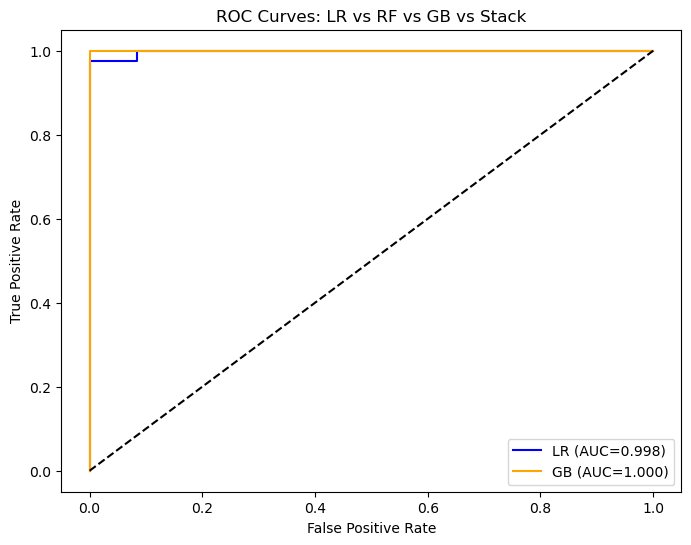

In [65]:
colors = {"lr":"blue", "rf":"green", "gb":"orange", "stack":"purple"}
plt.figure(figsize=(8,6))

for name in models:
    model = models[name]
    threshold = thresholds[name]

    y_prob = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)

    plt.plot(fpr, tpr, label=f"{name.upper()} (AUC={auc:.3f})", color=colors[name])

plt.plot([0,1],[0,1],"k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves: LR vs RF vs GB vs Stack")
plt.legend()
plt.show()

## Classification Report Summary Table

In [66]:
from sklearn.metrics import precision_recall_fscore_support


def compare_models(models, thresholds, X_test, y_test):
    records = []
    for name, model in models.items():
        # Predict probabilities
        y_prob = model.predict_proba(X_test)[:, 1]
        # Apply tuned threshold
        y_pred = (y_prob >= thresholds[name]).astype(int)

        # Confusion matrix
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

        # Metrics
        precision, recall, f1, _ = precision_recall_fscore_support(
            y_test, y_pred, average="binary", zero_division=0
        )
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
        auc = roc_auc_score(y_test, y_prob)
        accuracy = (tp + tn) / (tp + tn + fp + fn)

        records.append({
            "Model": name.upper(),
            "Threshold": round(thresholds[name], 2),
            "Precision": round(precision, 3),
            "Recall": round(recall, 3),
            "F1": round(f1, 3),
            "Specificity": round(specificity, 3),
            "ROC_AUC": round(auc, 3),
            "Accuracy": round(accuracy, 3),
            "Support": len(y_test)
        })

    return pd.DataFrame(records)

# Example usage (assuming you have dicts models + thresholds):
# models = {"lr": lr_model, "rf": rf_model, "gb": gb_model, "stack": stack_model}
# thresholds = {"lr": thr_lr, "rf": thr_rf, "gb": thr_gb, "stack": thr_stack}

results_df = compare_models(models, thresholds, X_test, y_test)
print(results_df)

  Model  Threshold  Precision  Recall     F1  Specificity  ROC_AUC  Accuracy  \
0    LR       0.45        1.0   0.976  0.988          1.0    0.998     0.991   
1    GB       0.39        1.0   1.000  1.000          1.0    1.000     1.000   

   Support  
0      114  
1      114  
